Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
# Set image size and batch size
image_size = (180, 180)
batch_size = 32

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=image_size,
                                                             batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

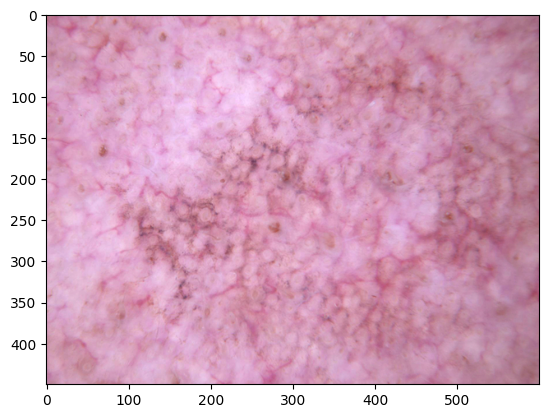

In [17]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

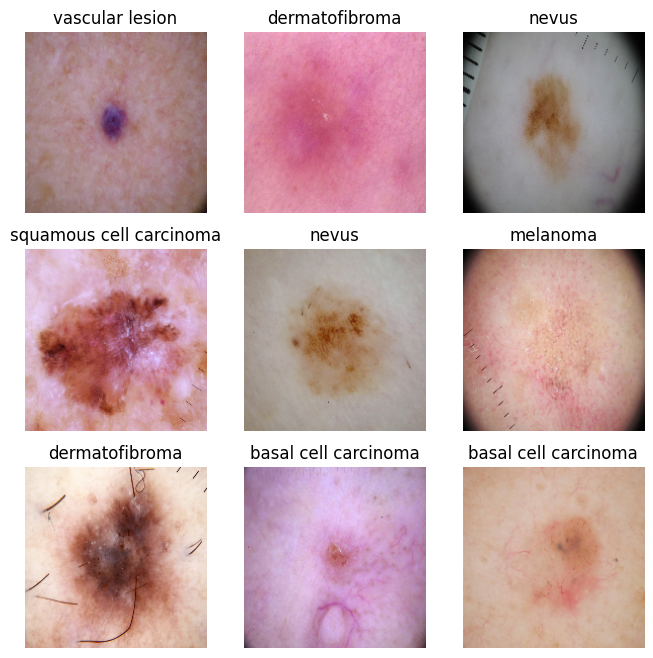

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [23]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [24]:
### Todo, choose an appropirate optimiser and loss function
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [26]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.2139 - loss: 6.1321 - val_accuracy: 0.3714 - val_loss: 1.7674
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.3658 - loss: 1.7790 - val_accuracy: 0.4183 - val_loss: 1.6614
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.4563 - loss: 1.5423 - val_accuracy: 0.4877 - val_loss: 1.4912
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.5035 - loss: 1.4388 - val_accuracy: 0.5123 - val_loss: 1.4503
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.4865 - loss: 1.4006 - val_accuracy: 0.4653 - val_loss: 1.5327
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5472 - loss: 1.2883 - val_accuracy: 0.4564 - val_loss: 1.5700
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5826 - loss: 1.1976 - val_accuracy: 0.5190 - val_loss: 1.4304
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.6540 - loss: 0.9878 - val_accuracy: 0.5145 - v

### Visualizing training results

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

-> Training accuracy is increasing linearly, but validation accuracy remains around 45 to 55% mark

-> As epochs increases, training loss increases and validation loss increases

-> This looks like overfitting model as there is a substancial difference between training and validation accuracy



In [31]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
image_height = 180
image_width = 180
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(image_height,image_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


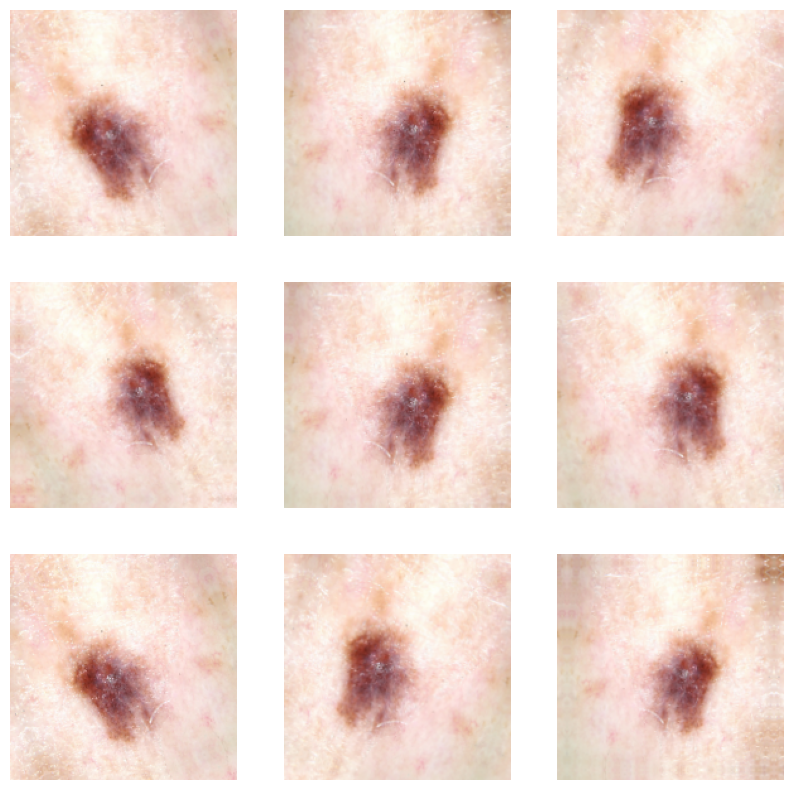

In [32]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [33]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))



### Compiling the model

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [35]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.2298 - loss: 4.4497 - val_accuracy: 0.3826 - val_loss: 1.6731
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.3803 - loss: 1.6712 - val_accuracy: 0.4340 - val_loss: 1.5616
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.4422 - loss: 1.5661 - val_accuracy: 0.5213 - val_loss: 1.4777
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.4741 - loss: 1.4571 - val_accuracy: 0.4698 - val_loss: 1.5222
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.5194 - loss: 1.4575 - val_accuracy: 0.4922 - val_loss: 1.4633
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.5095 - loss: 1.4039 - val_accuracy: 0.5056 - val_loss: 1.4124
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.5259 - loss: 1.3257 - val_accuracy: 0.5280 - val_loss: 1.4205
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.5379 - loss: 1.3109 - val_accuracy:

### Visualizing the results

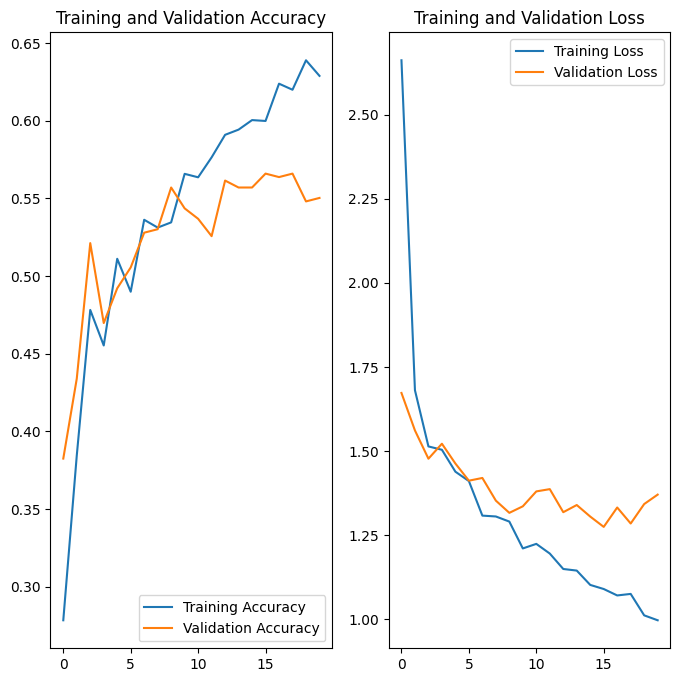

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

## Findings:

*  From the model,the difference is only slightly noticeable between training accuracy and validation accuracy. there is no substantial difference.


*   As the number of epochs increases, we are observing a gap between training loss and validation loss, which could be a sign of overfitting.







#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [37]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [38]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

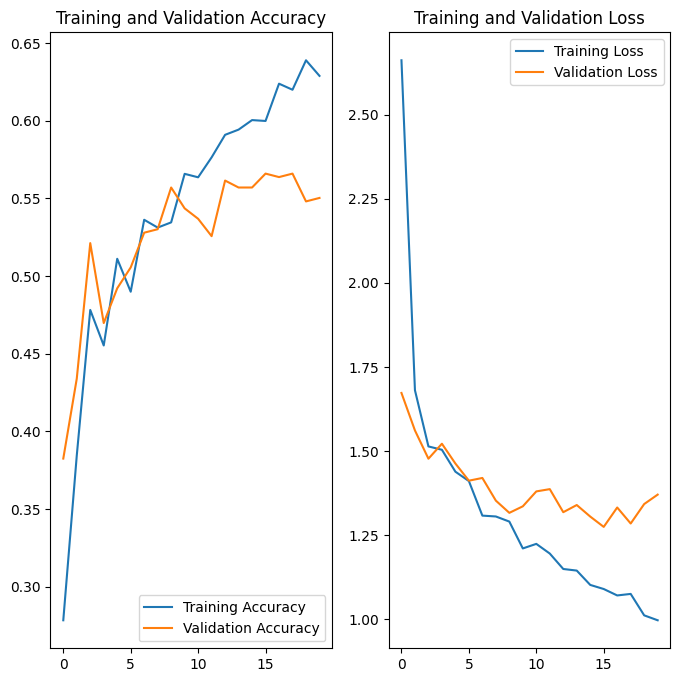

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?

*  seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?

*  pigmented benign keratosis





In [40]:
for i in range(len(class_names)):
  print(class_names[i],' ==> ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  ==>  114
basal cell carcinoma  ==>  376
dermatofibroma  ==>  95
melanoma  ==>  438
nevus  ==>  357
pigmented benign keratosis  ==>  462
seborrheic keratosis  ==>  77
squamous cell carcinoma  ==>  181
vascular lesion  ==>  139


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [41]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [42]:

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(data_dir_train)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE7A5F45090>: 100%|██████████| 500/500 [00:48<00:00, 10.21 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE7A5D879A0>: 100%|██████████| 500/500 [00:41<00:00, 11.96 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DE7A549C910>: 100%|██████████| 500/500 [00:40<00:00, 12.32 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE7A9F5A590>: 100%|██████████| 500/500 [00:41<00:00, 12.10 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE7A7459780>: 100%|██████████| 500/500 [00:41<00:00, 12.12 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7DE7A749AAA0>: 100%|██████████| 500/500 [00:42<00:00, 11.65 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7DE7A9A035E0>: 100%|██████████| 500/500 [00:42<00:00, 11.66 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE7A5F28CD0>: 100%|██████████| 500/500 [00:43<00:00, 11.60 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7DE7A9EF2770>: 100%|██████████| 500/500 [00:50<00:00,  9.97 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [43]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [44]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train1, '*', '*.jpg'))]


In [45]:
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train1, '*', '*.jpg'))]



In [46]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [47]:
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [48]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    930
melanoma                      852
basal cell carcinoma          789
nevus                         678
squamous cell carcinoma       389
vascular lesion               296
actinic keratosis             225
dermatofibroma                201
seborrheic keratosis          140
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [50]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [52]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [53]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 259200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │      66,355,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [54]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 238ms/step - accuracy: 0.1929 - loss: 5.1395 - val_accuracy: 0.3333 - val_loss: 1.7741
Epoch 2/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 38s 239ms/step - accuracy: 0.3221 - loss: 1.8024 - val_accuracy: 0.4156 - val_loss: 1.7458
Epoch 3/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.4796 - loss: 1.4674 - val_accuracy: 0.5367 - val_loss: 1.3636
Epoch 4/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.5070 - loss: 1.3605 - val_accuracy: 0.5267 - val_loss: 1.3402
Epoch 5/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 31s 275ms/step - accuracy: 0.5270 - loss: 1.2980 - val_accuracy: 0.5689 - val_loss: 1.2210
Epoch 6/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 26s 231ms/step - accuracy: 0.5564 - loss: 1.2011 - val_accuracy: 0.5678 - val_loss: 1.2286
Epoch 7/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.5626 - loss: 1.1759 - val_accuracy: 0.5678 - val_loss: 1.2264
Epoch 8/30
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 231ms/step - accuracy: 0.5824 - loss: 1

#### **Todo:**  Visualize the model results

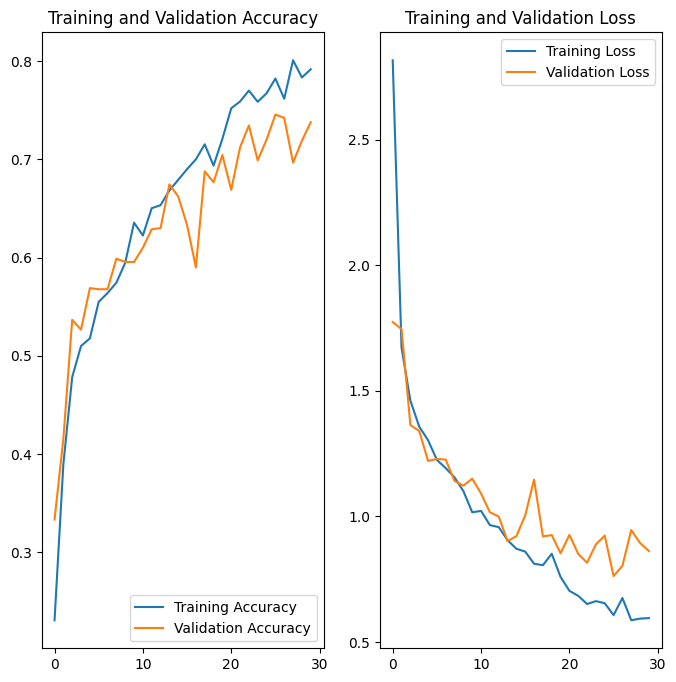

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?





*   Class rebalancing helped to increase the accuracy to approx 72 to 73%.
*    Class rebalancing eliminated the  validation loss and loss.

*  difference between training loss and validation loss decreased significantly


